<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020

## Proyecto lenguaje de señas

### Integrantes:
* Deisy Tatiana Macias
* Dayana Romero
* Juan José Villegas
* Juan Sebastián Méndez

# 0. Toma de datos

Para la toma de datos, se hizo un programa en nodeJS que utiliza el modelo "handpose" de media pipe con tensor flow. Este programa nos permite, por medio de la cámara del computador, tomar las coordenadas de todos los _landmarks_ de la mano (más detalles en el diccionario), siendo mostradas en un cuadro de texto que luego era copiado y pegado a un archivo de excel. El código fuente está en el siguiente repositorio: https://github.com/jjr2040/ml-sign-language.

<img src="./Images/TomaDatos.png" width=600px>

## Proceso de adquisición de datos

1. Con el programa abierto y listo para la adquisición, el usuario hace la seña correspondiente.
1. Una vez en posición, se oprime el botón "Record". Este empieza un proceso de adquisición de coordenadas que dura 5 segundos.
1. Una vez finalizados los cinco segundos, tenemos resultados en un área de texto que luego copiamos y pegamos en nuestro archivo de excel.

_Nota: La cantidad de datos por cada muestra de cinco segundos varía dependiendo de varios factores._

* _Los fps (frames por segundo) que logra la máquina en la que ejecuta el programa (ejemplo, 11 fps en la imagen anterior). El programa genera una fila de datos por cada frame._
* _La iluminación y otro factores que ayudan a reconocer mejor el patrón analizado. Esto debido a que se configuró para que el sistema imprimiera una fila de datos si el modelo usado tenia una certeza del 99% de que lo analizado es efectivamente una mano._

_Con esto en mente, el programa genera de 20 a 40 filas por cada muestra de 5 segundos._

## Señas a reconocer

### Número 0

<img src="./Images/Cero.png" >

### Número 1

<img src="./Images/Uno.png" >
<img src="./Images/Uno_f.png" >

### Número 2

<img src="./Images/Dos.png" >

### Número 3

<img src="./Images/Tres.png" >

### Número 4

<img src="./Images/Cuatro.png" >

### Número 5

<img src="./Images/Cinco.png" >

### Número 6

<img src="./Images/Seis.png" >

### Número 7

<img src="./Images/Siete.png" >

### Número 8

<img src="./Images/Ocho.png" >

### Número 9

<img src="./Images/Nueve.png" >

### Número 10

<img src="./Images/Diez.png" >

# 1. Importando las librerias requeridas

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
from pandas_profiling import ProfileReport

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 2. Perfilamiento y entendimiento de los datos

<img src="./Images/Landmarks.png" >

Los datos tal como vienen del programa nos arroja tres coordenadas por cada uno de los landmarks en donde la coordenada x=0 y y=0 son la esquina abajo izquierda de la imágen. El tamaño de la imágen es fija a 640x500 pixeles. Así nuestro rango para la coordenada x y y es de 0 <= x <= 640 y 0 <= y <= 500. La coordenada cero es relativa a un punto intermedio en la pantalla (que se vean todos los puntos centrados en pantalla). A medida que la mano se acerca a la cámara obtenemos valores positivos, y si se aleja nos arroja valores negativos.

In [2]:
diccionario = pd.read_csv('./data/diccionario.csv', encoding = "UTF-8")
data = pd.read_csv('./data/datos.csv', encoding = "UTF-8")

In [3]:
profile = ProfileReport(data)
profile.to_file("profile_report.html")

Se sacan los histogramas de las variables para ver cómo están distribuídas y encontrar posibilidades de mejora, tranformación y tratamientos de los datos 

array([[<AxesSubplot:title={'center':'clase'}>,
        <AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x1'}>,
        <AxesSubplot:title={'center':'x10'}>,
        <AxesSubplot:title={'center':'x11'}>,
        <AxesSubplot:title={'center':'x12'}>,
        <AxesSubplot:title={'center':'x13'}>,
        <AxesSubplot:title={'center':'x14'}>],
       [<AxesSubplot:title={'center':'x15'}>,
        <AxesSubplot:title={'center':'x16'}>,
        <AxesSubplot:title={'center':'x17'}>,
        <AxesSubplot:title={'center':'x18'}>,
        <AxesSubplot:title={'center':'x19'}>,
        <AxesSubplot:title={'center':'x2'}>,
        <AxesSubplot:title={'center':'x20'}>,
        <AxesSubplot:title={'center':'x3'}>],
       [<AxesSubplot:title={'center':'x4'}>,
        <AxesSubplot:title={'center':'x5'}>,
        <AxesSubplot:title={'center':'x6'}>,
        <AxesSubplot:title={'center':'x7'}>,
        <AxesSubplot:title={'center':'x8'}>,
        <AxesSubplot:title={'center':'x

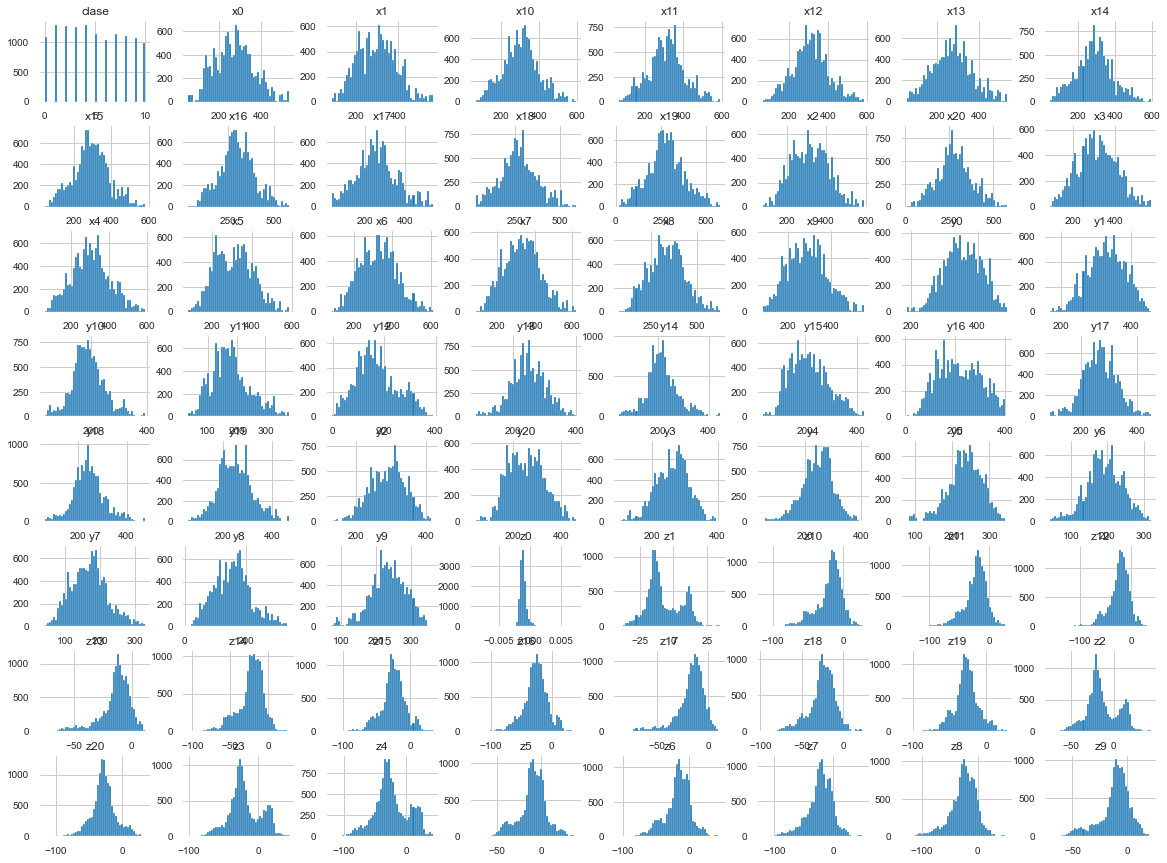

In [3]:
data.hist(bins=50, figsize=(20, 15))

# 3. Limpieza y preparación de datos

## 3.1 Limpieza de datos

Se considera que no se debe eliminar ninguna columna, porque los datos fueron tomados de una imagen y estos representan coordenadas que son necesarias en su completitud para determinar el número. Debido a esto, no consideramos aplicable un estudio de correlación. 

## 3.2 Preparación de datos

Ya que tenemos pocos datos, utilizamos una función que crea replicas de nuestro archivo de entrada agregando ruido gaussiano a cada una de las coordenadas. Con esto logramos aumentar la cantidad de datos.

In [3]:
def augment_data(data, augmentation_factor):
    noise_dataset = pd.DataFrame(columns=data.columns)
    mu, sigma = 0, 1.5
    X, y = data.drop(['clase'], axis=1), data['clase']
    
    for iteration in range(augmentation_factor):
        noise = np.random.normal(mu, sigma, X.shape)
        signal = X + noise
        signal['clase'] = y
        noise_dataset = noise_dataset.append(signal, ignore_index=True)
        
    return noise_dataset

In [4]:
X, y = data.drop(['clase'], axis=1), data['clase']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.4, random_state=33)
data_set=pd.DataFrame(columns=data.columns)
new = X_train
new['clase']=y_train
data_set=data_set.append(new, ignore_index=True)

data_generated = augment_data(data_set, 2)
data_augmented = data.append(data_generated)

X_train, y_train = data_augmented.drop(['clase'], axis=1), data_augmented['clase']

Ya que las coordenadas X y Y están dadas en número de pixeles, las normalizamos y escalamos para que no dependan del tamaño de la imagen.

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_ready = scaler.fit(X_train).transform(X_train)
X_test_ready = scaler.fit(X_test).transform(X_test)

y_train_1 = y_train.astype('int')
y_test_1 = y_test.astype('int')
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# 4. Modelamiento

Se implementaron varios algoritmos para comparar los niveles de rendimiento y escoger los algoritmos que mejor se adaptan al problema.

## 4.1. Red neuronal (MLP)

In [7]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]
n_output = 11
tf.keras.backend.set_floatx('float64')

In [8]:
def build_model(n_hidden=1, n_neurons_1 = 100, n_neurons_2 = 100, dropout = 0.1, activation_hidden = 'relu', learning_rate=3e-3):
    mlp = Sequential(name='lab_6_mlp')
    first = True

    for layer in range(n_hidden):
        if first:
            mlp.add(Dense(n_neurons_1, activation=activation_hidden, name=f'hidden_layer_{layer}'))
            first = False
        else:
            mlp.add(Dense(n_neurons_2, activation=activation_hidden, name=f'hidden_layer_{layer}'))
    
    mlp.add(Dropout(dropout,name=f'dropout_layer_{dropout}'))
    mlp.add(Dense(n_output, activation='sigmoid', name= 'output_layer'))

    sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    mlp.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])
    
    return mlp

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32, verbose=1,shuffle = True)

In [9]:
param_grid = dict(n_hidden = [1,2],
                  n_neurons_1 = [10, 30, 50, 100, 500, 1000],
                  n_neurons_2 = [10, 30, 50, 100, 500, 1000],
                  dropout = [0.1,0.2,0.3],
                  activation_hidden = ['relu','sigmoid'],
                  learning_rate = [0.03, 0.1, 0.3]
                  )

grid = RandomizedSearchCV(modelCV, param_grid, verbose=1, cv = 3, n_iter=10, random_state=20)
grid.fit(X_train_ready, y_train, callbacks=callbacks)

mlp_model = grid.best_estimator_
print(grid.best_params_)
print('Best score: ',grid.best_score_)
print(mlp_model)
mlp_model.model.summary()

=========================] - 1s 1ms/step - loss: 2.3441 - accuracy: 0.1178
Epoch 2/20
585/585 [==============================] - 1s 1ms/step - loss: 2.3305 - accuracy: 0.1194
Epoch 3/20
585/585 [==============================] - 1s 1ms/step - loss: 2.3251 - accuracy: 0.1245
Epoch 4/20
585/585 [==============================] - 1s 1ms/step - loss: 2.3144 - accuracy: 0.1278
Epoch 5/20
585/585 [==============================] - 1s 1ms/step - loss: 2.2809 - accuracy: 0.1427
Epoch 6/20
585/585 [==============================] - 1s 2ms/step - loss: 2.1658 - accuracy: 0.2001
Epoch 7/20
585/585 [==============================] - 1s 1ms/step - loss: 1.9553 - accuracy: 0.2601
Epoch 8/20
585/585 [==============================] - 1s 1ms/step - loss: 1.7032 - accuracy: 0.3400
Epoch 9/20
585/585 [==============================] - 1s 2ms/step - loss: 1.4560 - accuracy: 0.4266
Epoch 10/20
585/585 [==============================] - 1s 1ms/step - loss: 1.2548 - accuracy: 0.5012
Epoch 11/20
585/585 [===

## 4.2 Näive Bayes

In [10]:
NB = MultinomialNB().fit(X_train_ready,y_train_1)
NB

MultinomialNB()

## 4.3 SVM

In [11]:
parametros = {'gamma':[0.005, 5, 10],'C': [5e3, 1e4, 5e4]}

GridSearchCV(SVC(kernel='rbf'), param_grid=parametros).fit(X_train_ready, y_train_1).best_estimator_

SVC(C=5000.0, gamma=5)

In [12]:
svc = SVC(kernel='rbf', gamma=5, C=5000, decision_function_shape='ovr')
svc.fit(X_train_ready, y_train_1.ravel())

SVC(C=5000, gamma=5)

## 4.3 Random Forest

In [6]:
random_forest_clf = RandomForestClassifier(n_jobs=-1)

In [7]:
random_forest_clf.fit(X_train_ready, y_train)

RandomForestClassifier(n_jobs=-1)

## 4.3 SGD Classifier

In [15]:
sgd_clf = SGDClassifier(n_jobs=-1, early_stopping=True, verbose=20)

In [16]:
param_grid = {
    'alpha': [1E-4, 1E-2, 1E-1, 1, 1E1],
    'max_iter': [1000, 10000, 30000]
}

grid_sgd_clf = GridSearchCV(sgd_clf, param_grid)
%time grid_sgd_clf.fit(X_train_ready, y_train_1)
grid_sgd_clf.best_params_

]: Done   9 out of  11 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
Norm: 0.06, NNZs: 63, Bias: -0.755678, T: 60606, Avg. loss: 0.154797
Total training time: 0.03 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.777563, T: 60606, Avg. loss: 0.145723-- Epoch 4

Total training time: 0.03 seconds.
-- Epoch 4
-- Epoch 4
Norm: 0.06, NNZs: 63, Bias: -0.772687, T: 80808, Avg. loss: 0.164231
Total training time: 0.04 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.760599, T: 80808, Avg. loss: 0.154635-- Epoch 5

Total training time: 0.04 seconds.
Norm: 0.06, NNZs: 63, Bias: -0.782603, T: 80808, Avg. loss: 0.145500
Total training time: 0.04 seconds.
-- Epoch 5
-- Epoch 5
Norm: 0.06, NNZs: 63, Bias: -0.776336, T: 101010, Avg. loss: 0.164083
Total training time: 0.05 seconds.
-- Epoch 6
Norm

{'alpha': 0.0001, 'max_iter': 30000}

In [17]:
grid_sgd_clf.best_score_

0.8691643908405657

# 5. Predicciones

## 5.1. Predicción (Red neuronal)

In [18]:
predict_train = mlp_model.predict(X_train_ready)
predict_test = mlp_model.predict(X_test_ready)
predict_train = pd.get_dummies(predict_train)
predict_test = pd.get_dummies(predict_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
160/160 [==============================] - 0s 596us/step


## 5.2 Predicción (Näive Bayes)

In [19]:
predict_train_NB = NB.predict(X_train_ready)
predict_test_NB = NB.predict(X_test_ready)

## 5.3 Predicción (SVM)

In [20]:
predict_train_SVM = svc.predict(X_train_ready)
predict_test_SVM = svc.predict(X_test_ready)

## 5.4 Predicción (Random Forest)

In [9]:
y_predict_train = random_forest_clf.predict(X_train_ready)
y_predict_test = random_forest_clf.predict(X_test_ready)

## 5.5 Predicción (SGD Classifier)

In [22]:
y_predict = grid_sgd_clf.predict(X_test_ready)
y_predict

array([2, 2, 8, ..., 8, 6, 3])

# 6. Validaciones

## 6.1. Validación (Red neuronal)

In [23]:
print('Resultados sobre train')
print(classification_report(y_train, predict_train))
print('Resultados sobre test')
print(classification_report(y_test, predict_test))

Resultados sobre train
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2321
           1       0.98      0.99      0.99      2806
           2       1.00      0.98      0.99      2740
           3       0.99      0.95      0.97      2845
           4       0.95      0.99      0.97      2859
           5       0.99      1.00      0.99      2588
           6       0.99      0.98      0.98      2316
           7       0.98      0.97      0.98      2584
           8       0.98      0.86      0.91      2483
           9       0.87      1.00      0.93      2340
          10       1.00      1.00      1.00      2176

   micro avg       0.97      0.97      0.97     28058
   macro avg       0.98      0.98      0.97     28058
weighted avg       0.98      0.97      0.97     28058
 samples avg       0.97      0.97      0.97     28058

Resultados sobre test
              precision    recall  f1-score   support

           0       1.00      1.00

Text(50.760000000000005, 0.5, 'predicted label')

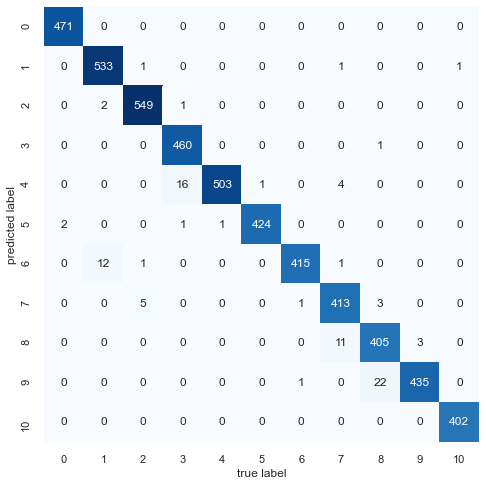

In [24]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.values.argmax(axis=1), predict_test.values.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9, 10])
plt.xlabel('true label')
plt.ylabel('predicted label')

## 6.2 Validación (Näive Bayes)

In [25]:
report_NB = classification_report(y_train_1, predict_train_NB, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for Näive Bayes train\n", report_NB)

report_NB = classification_report(y_test_1, predict_test_NB, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for Näive Bayes test\n", report_NB)

Test Report for Näive Bayes train
               precision    recall  f1-score   support

           0       0.58      0.75      0.66      2321
           1       0.69      0.67      0.68      2806
           2       0.57      0.61      0.59      2740
           3       0.45      0.58      0.51      2845
           4       0.35      0.36      0.36      2859
           5       0.80      0.46      0.58      2588
           6       0.39      0.34      0.36      2316
           7       0.27      0.31      0.28      2584
           8       0.22      0.28      0.25      2483
           9       0.48      0.18      0.26      2340
          10       0.91      0.92      0.92      2176

    accuracy                           0.49     28058
   macro avg       0.52      0.50      0.49     28058
weighted avg       0.51      0.49      0.49     28058

Test Report for Näive Bayes test
               precision    recall  f1-score   support

           0       0.62      0.77      0.69       473
         

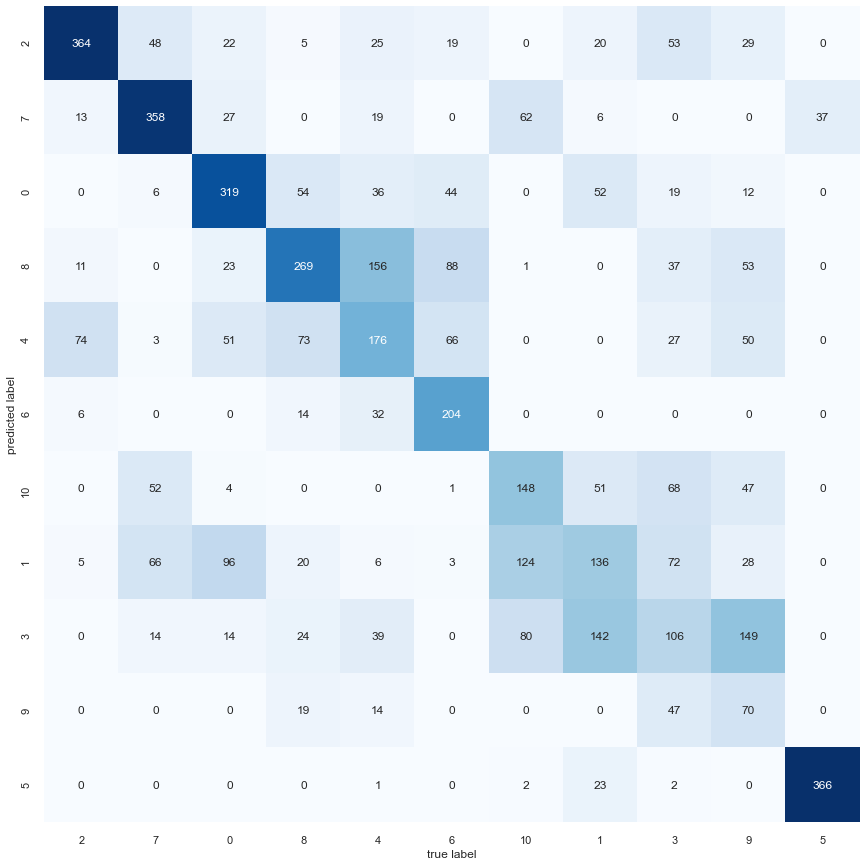

In [26]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,15))
mat = confusion_matrix(y_test_1, predict_test_NB)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y_test_1.unique(),
            yticklabels=y_test_1.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

## 6.3 Validación (SVM)

In [27]:
report_svc = classification_report(y_train_1, predict_train_SVM, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for SVC train with normalization\n", report_svc)

report_svc = classification_report(y_test_1, predict_test_SVM, [0,1,2,3,4,5,6,7,8,9,10])
print("Test Report for SVC test with normalization\n", report_svc)

Test Report for SVC train with normalization
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2321
           1       1.00      1.00      1.00      2806
           2       1.00      1.00      1.00      2740
           3       1.00      1.00      1.00      2845
           4       1.00      1.00      1.00      2859
           5       1.00      1.00      1.00      2588
           6       1.00      1.00      1.00      2316
           7       1.00      1.00      1.00      2584
           8       1.00      1.00      1.00      2483
           9       1.00      1.00      1.00      2340
          10       1.00      1.00      1.00      2176

    accuracy                           1.00     28058
   macro avg       1.00      1.00      1.00     28058
weighted avg       1.00      1.00      1.00     28058

Test Report for SVC test with normalization
               precision    recall  f1-score   support

           0       1.00      1.00      1.

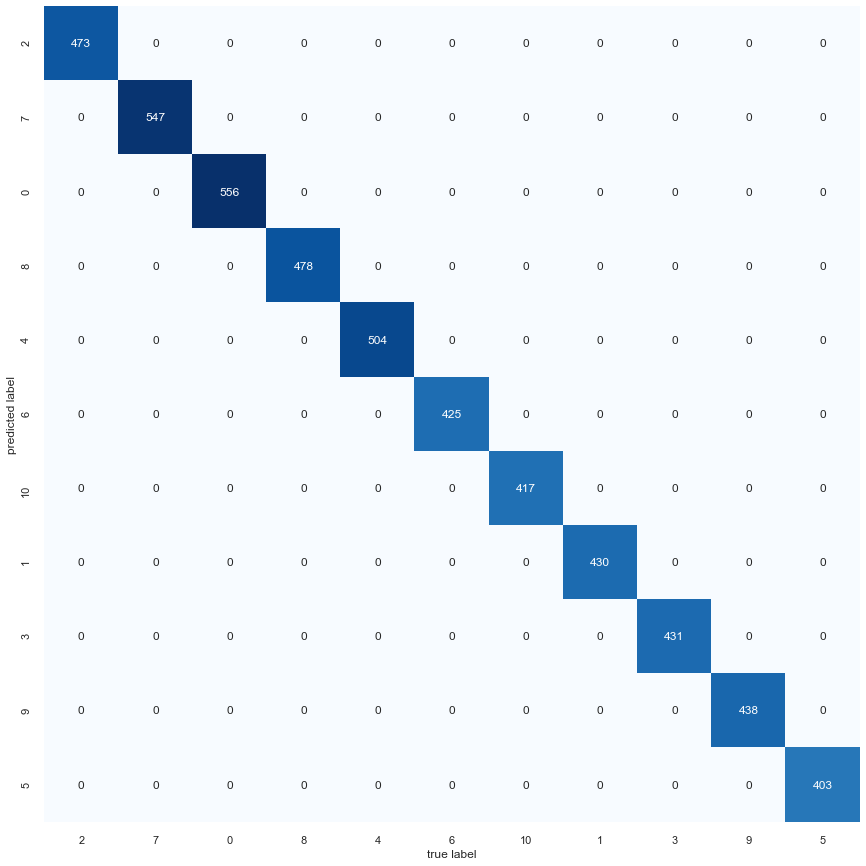

In [28]:
import seaborn as sns; sns.set()

plt.figure(figsize=(15,15))
mat = confusion_matrix(y_test_1, predict_test_SVM)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y_test_1.unique(),
            yticklabels=y_test_1.unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

## 6.4. Validación (Random Forest)

In [29]:
report_random_forest_clf_train = classification_report(y_train, y_predict_train)
report_random_forest_clf_test = classification_report(y_test, y_predict_test)
print("Test Report for train\n", report_random_forest_clf_train)
print("Test Report for test\n", report_random_forest_clf_test)

Test Report for train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2321
           1       1.00      1.00      1.00      2806
           2       1.00      1.00      1.00      2740
           3       1.00      1.00      1.00      2845
           4       1.00      1.00      1.00      2859
           5       1.00      1.00      1.00      2588
           6       1.00      1.00      1.00      2316
           7       1.00      1.00      1.00      2584
           8       1.00      1.00      1.00      2483
           9       1.00      1.00      1.00      2340
          10       1.00      1.00      1.00      2176

   micro avg       1.00      1.00      1.00     28058
   macro avg       1.00      1.00      1.00     28058
weighted avg       1.00      1.00      1.00     28058
 samples avg       1.00      1.00      1.00     28058

Test Report for test
               precision    recall  f1-score   support

           0       1.00      1.00

Text(50.760000000000005, 0.5, 'predicted label')

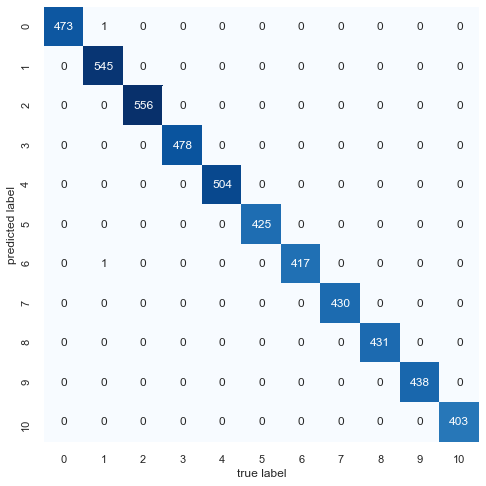

In [30]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.values.argmax(axis=1), y_predict_test.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('true label')
plt.ylabel('predicted label')

## 6.5. Validación (GDC Classifier)

In [31]:
report_sgd_clf = classification_report(y_test_1, y_predict)
print("Test Report\n", report_sgd_clf)

Test Report
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       473
           1       0.99      0.95      0.97       547
           2       0.88      0.99      0.93       556
           3       0.97      0.96      0.96       478
           4       0.75      0.83      0.79       504
           5       0.79      0.72      0.76       425
           6       0.87      0.98      0.92       417
           7       0.99      0.27      0.42       430
           8       0.48      0.98      0.64       431
           9       0.94      0.42      0.58       438
          10       1.00      1.00      1.00       403

    accuracy                           0.83      5102
   macro avg       0.88      0.83      0.81      5102
weighted avg       0.88      0.83      0.82      5102



Text(50.760000000000005, 0.5, 'predicted label')

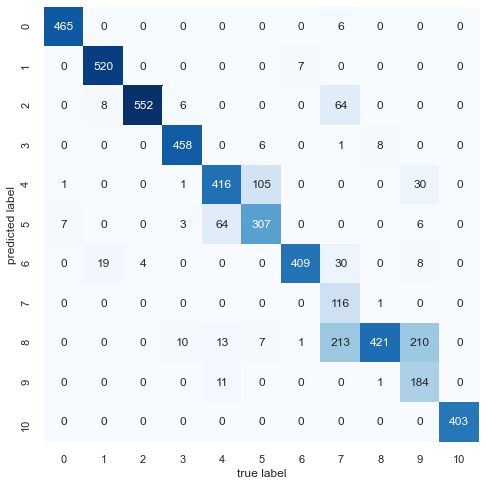

In [32]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test_1, y_predict)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('true label')
plt.ylabel('predicted label')

# 7. Resultados finales
## 7.1. Módulo para datos nuevos

Cualquier dato nuevo tiene que pasar por el filtrado descrito en el numeral 3.2. Es decir, pasar por un escalado usando un minmax que vaya de 0 a 1. De esta forma, mientras vengan en el mismo formato, el sistema es capáz de usar la función de predicción para generar los Resultados.

<img src="https://techblog.cdiscount.com/assets/images/DataScience/automl/ML_process.png" width="600">

In [ ]:
# Feature engineering para este problema
scaler = MinMaxScaler(feature_range=(0,1))
X_New = scaler.fit(X_New).transform(X_New)

## 7.2. Construcción del modelo final

Obtuvimos resultados casi perfectos con Random Forest y SVM, y unos muy buenos con el perceptrón multicapa. Sin embargo se decide dejar como modelo definitivo el Random Forest por su velocidad de ejecución. Sin embargo, el SVM podría ser una opción igualmente válida en otros contextos de ejecución tales como móviles, ya que el modelo generado y exportado consume menos espacio en disco que el Random Forest.

De esta forma los hiperparámetros definitivos son los siguientes:

### Modelo: Random Forest.
* Min Samples split: 2.
* Min Samples leave: 1.
* Max depth: None.
* Criterion: Gini.
* N Estimators: 100.

## 7.3. Métricas de rendimiento finales

In [10]:
report_random_forest_clf_train = classification_report(y_train, y_predict_train)
report_random_forest_clf_test = classification_report(y_test, y_predict_test)
print("Test Report for train\n", report_random_forest_clf_train)
print("Test Report for test\n", report_random_forest_clf_test)

Test Report for train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2321
           1       1.00      1.00      1.00      2806
           2       1.00      1.00      1.00      2740
           3       1.00      1.00      1.00      2845
           4       1.00      1.00      1.00      2859
           5       1.00      1.00      1.00      2588
           6       1.00      1.00      1.00      2316
           7       1.00      1.00      1.00      2584
           8       1.00      1.00      1.00      2483
           9       1.00      1.00      1.00      2340
          10       1.00      1.00      1.00      2176

   micro avg       1.00      1.00      1.00     28058
   macro avg       1.00      1.00      1.00     28058
weighted avg       1.00      1.00      1.00     28058
 samples avg       1.00      1.00      1.00     28058

Test Report for test
               precision    recall  f1-score   support

           0       1.00      1.00

Text(50.760000000000005, 0.5, 'predicted label')

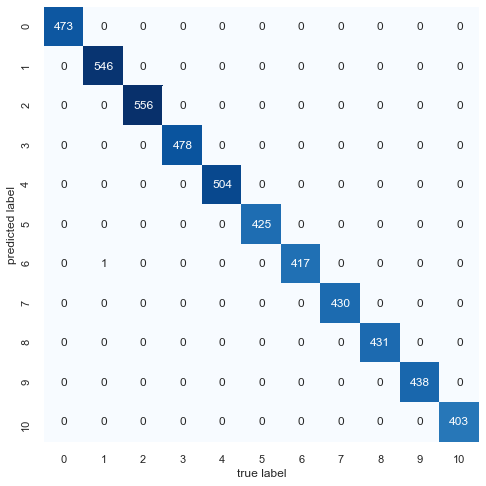

In [11]:
sns.set()
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.values.argmax(axis=1), y_predict_test.argmax(axis=1))
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False, xticklabels=[0,1,2,3,4,5,6,7,8,9,10], yticklabels=[0,1,2,3,4,5,6,7,8,9,10])
plt.xlabel('true label')
plt.ylabel('predicted label')

## 7.4 Presentación de resultados (DEMO)

Para poder validar que lo que se hizo sí estuviera funcionando en casos más reales, se construyó una página web que, mediante la cámara web, permitía predecir las señas que se le muestran. Para poder hacer esto se tuvo que migrar el modelo entrenado de Random Forest a Javascript para poder ser corrido por el explorador. Se usó una herramienta llamada Sklearn Porter (https://github.com/nok/sklearn-porter) para tal fin. A continuación, se muestra cómo se hizo para hacer esa exportación:

In [ ]:
from sklearn_porter import Porter

porter = Porter(random_forest_clf, language='js')
output = porter.export(embed_data=True)

with open('RandomForestClassifier.js', 'w') as f:
    f.write(output)

El anterior archivo generado de javascript, es el modelo ya pre entrenado que sirve para ser importado en el script que termina haciendo la predicción como tal. A continuación, una screenshot del programa resultante.

<img src="./images/demo.png" width="600">

## 7.5. Trabajo futuro

El prototipo construido se ve como una prueba de concepto con resultados muy buenos. Sin embargo, este es sólo una pequeña parte de lo que sería el modelamiento completo de un lenguaje de señas. A continuación presentamos varias propuestas de trabajo futuro:

* **Reconocimiento de las dos manos:** Muchas de las palabras en el lenguaje de señas Colombiano se hace por medio de las dos manos. Aprender a reconocerlas e interpretarlas nos abre la posibilidad de reconocer todas las palabras y conceptos del lenguaje.

* **Reconocimiento de señas con movimiento:** La mayoría de las señas en el lenguaje no son estáticas. Por el contrario, tienen un movimiento que puede llegar a representar diferentes cosas. Extender el modelo para reconocer una serie de movimiento sería necesaria para lograr reconocer todas las palabras.

* **Reconocimiento de varios tipos de lenguaje de señas:** Cada país tiene su propia implementación del lenguaje de señas. Reconocer las diferencias podría hacer el modelo más genérico al incluir diferentes tipos de implementaciones.

* **Unificación de modelos:** Ahora mismo utilizamos la salida del model handpose, de Mediapipe, como entrada a nuestro modelo. Se podría ahorrar este paso intermedio por medio de la unificación de modelos.

* **Aplicaciones:** Implementar el modelo en aplicaciones web y móviles que puedan ser usadas por el público. Con el fin de que se puede usar como herramienta de comunicación en los establecimientos, tanto públicos como privados. 


# 8. Conclusiones

* Dado que somos nosotros mismos los que tomamos los datos, no tuvimos que hacer mayor tratamiendo de los mismos. Los datos fueron pensados desde el principio para funcionar dentro de nuestro alcance del proyecto.

* Aumentar los datos con ruido gaussiano nos permitió tener mejores resultados en la mayoría de los algoritmos probados.

* Se probaron cinco tipos diferentes de algoritmos con resultados variados, logrando en varios de ellos clasificaciones casi perfectas. Los de peor rendimiento fueron Bayes y el GDC Classifier. Mientras que los de mejor rendimiento fueron Random Forest, SVM, y el MLP.

* Por simplicidad a la hora de ser exportado (para implementaciones futuras), consideramos que el SVM y el random forest son los de mejor rendimiento, aunque no descartamos la viabilidad de uso de la red neuronal.

* Se decidió utilizar el modelo de Random Forest por su velocidad a la hora de predecir. Sin embargo nos dimos cuenta que en contextos donde el espacio en disco sea crítico (móviles, por ejemplo) el SVM es igualmente válido y más pequeño.

* Los resultados parecen ideales, y al principio sospechamos mucho de ellos, pero los datos al parecer no se sobrelapan mucho, ayudando a clasificarlos de forma muy precisa.

* Nos falta mucho para poder traducir lenguaje de señas, esto sirvió más como prueba de concepto. El lenguaje de señas es más complejo, hay que no sólo clasificar datos estáticos sino también movimiento para tener un completo entendimiento de lo que se intenta expresar. Las Redes Neuronales Recurrentes parecen un buen punto de partida para este caso en particular.

* Para que esto funcione en la práctica bien, nuestro modelo depende de qué tan preciso sea la predicción del modelo de entrada utilizado (handpose) y éste puede fallar en algunos casos y por lo tanto confundir nuestro modelo. Esa es una de las más grandes limitantes de la solución propuesta.

* Sabemos que para poder realmente generalizar mejor y ver los resultados de nuestro modelo, hay que tener muchísimo más datos y más diversos en casos no ideales. Los resultados en este ejercicio son ideales dadas las circunstancias.